In [1]:
!pip install -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.17
    Uninstalling albumentations-1.4.17:
      Successfully uninstalled albumentations-1.4.17


In [2]:
import albumentations as A
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from tqdm import tqdm
from random import choices

In [3]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.RandomResizedCrop(size = 640,width = 640,scale = (0.3,1.0),ratio = (0.75,1.33)),
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels'],min_area=0.2))

In [4]:
""" DO UPDATE THIS"""

anno_path = "/kaggle/input/flipkart-grid-data/dataset3/anno"
image_path = "/kaggle/input/flipkart-grid-data/dataset3/images"
labels = "/kaggle/input/flipkart-grid-data/dataset3/labels.json"


In [5]:
os.makedirs("train/images",exist_ok = True)
os.makedirs("train/labels",exist_ok = True)
os.makedirs("val/labels",exist_ok = True)
os.makedirs("val/images",exist_ok = True)

In [6]:
with open(labels) as c:
    class_names= json.load(c)
c2i = class_names['c2i']
i2c = {int(i):v for i,v in class_names['i2c'].items()}

In [7]:
def show_image(image, bboxes, labels, yolo=False):
    print("bboxes",bboxes)
    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    for bbox,label in zip(bboxes,labels):
        if yolo:
            cx,cy,w,h = bbox
            x_min = (cx - w/2)*image.shape[0]
            y_min = (cy - h/2)*image.shape[1]
            x_max = (cx + w/2)*image.shape[0]
            y_max = (cy + h/2)*image.shape[1]
            
        else:
            x_min,y_min,x_max,y_max = bbox
        
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                 linewidth=2, edgecolor='r', facecolor='none',)
        ax.add_patch(rect)
        ax.text((x_min+x_max)/2, (y_min+y_max)/2,label,ha='center',va='center',fontsize=8)
    plt.show()

In [8]:
def box_labels(path_anno):
    with open(path_anno) as p:
        data = json.load(p)
        rects = []
        labels = []
        boxes = data['objects']
        for box in boxes:
            l = box['label']
            coords = []
            coords.extend(box['points'][0]) 
            coords.extend(box['points'][1]) 
            rects.append(coords)
            labels.append(i2c[l]) 
    return rects, labels

bboxes [[113.73873873873873, 40.99099099099099, 288.5135135135135, 359.90990990990986]]


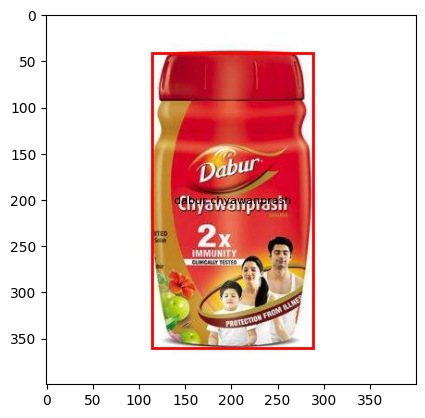

In [9]:
box,labels = box_labels("/kaggle/input/flipkart-grid-data/dataset3/anno/452.json")
im = cv2.imread("/kaggle/input/flipkart-grid-data/dataset3/images/452.jpg")

show_image(im,box,labels)

In [10]:
def pascal_voc_to_yolo(bbox, image_width, image_height):

    x_min, y_min, x_max, y_max = bbox

    x_center = (x_min + x_max) / 2 / image_width
    y_center = (y_min + y_max) / 2 / image_height
    width = (x_max - x_min) / image_width
    height = (y_max - y_min) / image_height

    return [x_center,y_center,width,height]

In [12]:
yaml = f"""

train: ../train/images
val: ../val/images

nc: {len(c2i)+4}
names: {['fresh apple', 'fresh banana', 'rotten apple', 'rotten banana']+list(c2i.keys())}

"""

with open("data.yaml","w") as f:
    f.write(yaml)

In [13]:
for im_path in tqdm(os.listdir(image_path)):
    anno = os.path.join(anno_path,im_path.replace('.jpg','.json'))
    image = cv2.imread(os.path.join(image_path,im_path))
    boxes,labels = box_labels(anno)
    try:
        for i in range(10):
            target_folder = choices(['train','val'],[0.9,0.1],k=1)[0]
            target_name = im_path.replace(".jpg",f"_{i}") 
            target_image_path = os.path.join(target_folder,"images",target_name+'.jpg')
            target_label_path = os.path.join(target_folder,"labels",target_name+'.txt')
            if boxes:
                while True:
                    transformed = transform(image = image,bboxes = boxes,class_labels = labels)
                    if len(transformed['bboxes'])>0:
                        t_image=transformed['image']
                        t_bboxes=transformed['bboxes']
                        t_classes=transformed['class_labels']
                        break
            else:
                transformed = transform(image = image,bboxes = boxes,class_labels = labels)
                t_image=transformed['image']
                t_bboxes=transformed['bboxes']
                t_classes=transformed['class_labels']
    
            with open(target_label_path,"w") as f: 
                for l,b in zip(t_classes,t_bboxes):
                    yolo_box = pascal_voc_to_yolo(b,640,640)
                    write = str(c2i[l])+" " + " ".join(str(point) for point in yolo_box) + "\n"
                    f.write(write)
                    
            cv2.imwrite(target_image_path,t_image)
    except Exception as e:
        print(im_path)
        

  1%|          | 39/5757 [00:24<21:52,  4.36it/s]

old-456.jpg


 14%|█▎        | 783/5757 [07:16<13:59,  5.92it/s]

old-166.jpg


 19%|█▉        | 1120/5757 [10:14<22:32,  3.43it/s]

old-1591.jpg


 44%|████▎     | 2517/5757 [23:01<38:14,  1.41it/s]

old-1581.jpg


 51%|█████▏    | 2952/5757 [26:44<15:52,  2.94it/s]

old-721.jpg


 53%|█████▎    | 3042/5757 [27:34<31:03,  1.46it/s]

773.jpg


 54%|█████▍    | 3115/5757 [28:23<10:39,  4.13it/s]

old-1582.jpg


 57%|█████▋    | 3255/5757 [29:47<31:35,  1.32it/s]

old-165.jpg


 57%|█████▋    | 3303/5757 [30:16<12:59,  3.15it/s]

old-1584.jpg


 65%|██████▍   | 3720/5757 [34:01<11:16,  3.01it/s]

old-730.jpg


 80%|████████  | 4631/5757 [41:43<08:36,  2.18it/s]

old-725.jpg


 83%|████████▎ | 4803/5757 [43:48<02:04,  7.65it/s]

old-1585.jpg


100%|██████████| 5757/5757 [52:45<00:00,  1.82it/s]


In [14]:
fruit_anno_path = "/kaggle/input/fkg-fruitdata/fruit_dataset/anno"
fruit_image_path = "/kaggle/input/fkg-fruitdata/fruit_dataset/images"
c2i = {'fresh apple': 0, 'fresh banana': 1, 'rotten apple': 2, 'rotten banana': 3}
i2c = {v:i for i,v in c2i.items()}

In [15]:
for im_path in tqdm(os.listdir(fruit_image_path)):
    anno = os.path.join(fruit_anno_path,im_path.replace('.jpg','.json'))
    image = cv2.imread(os.path.join(fruit_image_path,im_path))
    boxes,labels = box_labels(anno)
    try:
        for i in range(10):
            target_folder = choices(['train','val'],[0.9,0.1],k=1)[0]
            target_name = "fruit_" + im_path.replace(".jpg",f"_{i}") 
            target_image_path = os.path.join(target_folder,"images",target_name+'.jpg')
            target_label_path = os.path.join(target_folder,"labels",target_name+'.txt')
            if boxes:
                while True:
                    transformed = transform(image = image,bboxes = boxes,class_labels = labels)
                    if len(transformed['bboxes'])>0:
                        t_image=transformed['image']
                        t_bboxes=transformed['bboxes']
                        t_classes=transformed['class_labels']
                        break
            else:
                transformed = transform(image = image,bboxes = boxes,class_labels = labels)
                t_image=transformed['image']
                t_bboxes=transformed['bboxes']
                t_classes=transformed['class_labels']
    
            with open(target_label_path,"w") as f: 
                for l,b in zip(t_classes,t_bboxes):
                    yolo_box = pascal_voc_to_yolo(b,640,640)
                    write = str(c2i[l])+" " + " ".join(str(point) for point in yolo_box) + "\n"
                    f.write(write)
                    
            cv2.imwrite(target_image_path,t_image)
    except Exception as e:
        print(im_path)
        

100%|██████████| 440/440 [01:30<00:00,  4.87it/s]
